In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
main_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
training_loader = torch.utils.data.DataLoader(main_data, batch_size=100, shuffle=True)
val_main_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)
validation_loader = torch.utils.data.DataLoader(val_main_data, batch_size=100, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.73MB/s]


In [ ]:
def convert(con):
  image = con.cpu().clone().detach().numpy()
  image = np.transpose(image, (1, 2, 0))
  image = image.reshape((28, 28))
  image = image * (np.array(0.5,) + np.array(0.5,))
  image = image.clip(0, 1)
  return image

In [ ]:
print(main_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )


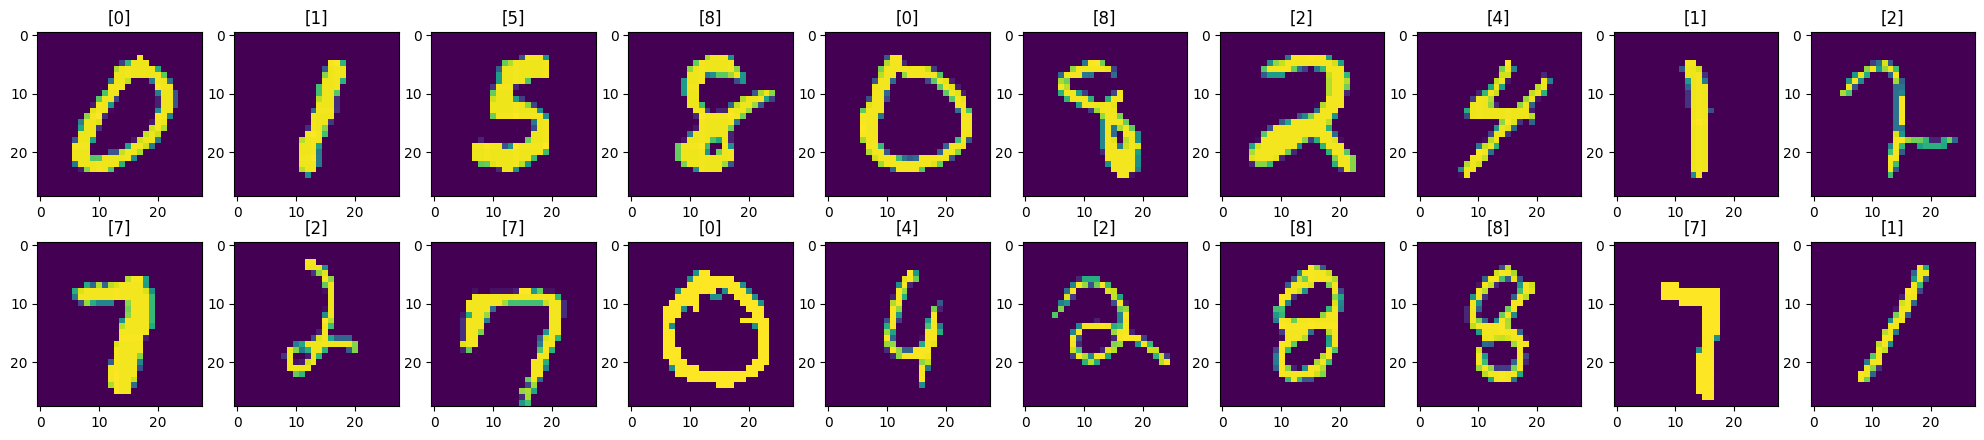

In [ ]:
iteration = iter(training_loader)
images, lable = next(iteration)
images.to(device)
lable.to(device)
fig = plt.figure(figsize=(25, 5))

for i in np.arange(20):
  ax = fig.add_subplot(2, 10, i+1)
  plt.imshow(convert(images[i]))
  ax.set_title([lable[i].item()])

In [ ]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 20, 5, 1)
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    self.fc1 = nn.Linear(4*4*50, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 100)
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x ,2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x ,2, 2)
    x = x.view(-1, 4*4*50)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

In [ ]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
)

In [ ]:
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
epochs = 15
loss_history = []
accu_history = []
val_loss_history = []
val_accu_history = []

for i in range(epochs):
  losse = 0.0
  accurecy = 0.0
  val_losse = 0.0
  val_accurecy = 0.0
  for input, lables in training_loader:
    input = input.to(device)
    lables = lables.to(device)
    output = model(input)
    loss = loss_fun(output, lables)

    _, preds = torch.max(output, 1)
    losse += loss.item()
    accurecy += torch.sum(preds == lables.data).item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  else:
    with torch.no_grad():
      for val_input, val_lables in validation_loader:
        val_input = val_input.to(device)
        val_lables = val_lables.to(device)
        val_output = model(val_input)
        val_loss = loss_fun(val_output, val_lables)

        _, val_preds = torch.max(val_output, 1)
        val_losse += val_loss.item()
        val_accurecy += torch.sum(val_preds == val_lables.data).item()

      running_loss= losse / len(training_loader)
      running_accu = accurecy / len(training_loader.dataset)
      loss_history.append(running_loss)
      accu_history.append(running_accu)

      val_running_loss= val_losse / len(validation_loader)
      val_running_accu = val_accurecy / len(validation_loader.dataset)
      val_loss_history.append(val_running_loss)
      val_accu_history.append(val_running_accu)

      print(f"epoch: {i} ".format(i+1))
      print("training loss: {:.4f}  ACC: {:.4f}".format(running_loss, running_accu))
      print("val_loss: {:.4f}  val_ACC: {:.4f}".format(val_running_loss, val_running_accu))

epoch: 0 
training loss: 0.9323  ACC: 0.7243
val_loss: 0.2588  val_ACC: 0.9229
epoch: 1 
training loss: 0.1977  ACC: 0.9428
val_loss: 0.1323  val_ACC: 0.9602
epoch: 2 
training loss: 0.1246  ACC: 0.9628
val_loss: 0.0903  val_ACC: 0.9751
epoch: 3 
training loss: 0.0941  ACC: 0.9718
val_loss: 0.0730  val_ACC: 0.9775
epoch: 4 
training loss: 0.0759  ACC: 0.9772
val_loss: 0.0603  val_ACC: 0.9808
epoch: 5 
training loss: 0.0664  ACC: 0.9800
val_loss: 0.0554  val_ACC: 0.9815
epoch: 6 
training loss: 0.0572  ACC: 0.9829
val_loss: 0.0502  val_ACC: 0.9844
epoch: 7 
training loss: 0.0508  ACC: 0.9852
val_loss: 0.0457  val_ACC: 0.9841
epoch: 8 
training loss: 0.0465  ACC: 0.9858
val_loss: 0.0416  val_ACC: 0.9869
epoch: 9 
training loss: 0.0423  ACC: 0.9873
val_loss: 0.0400  val_ACC: 0.9870


In [ ]:
plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='loss')
plt.legend()


In [ ]:
plt.plot(accu_history, label='accu')
plt.plot(val_accu_history, label='val_accu')
plt.legend()

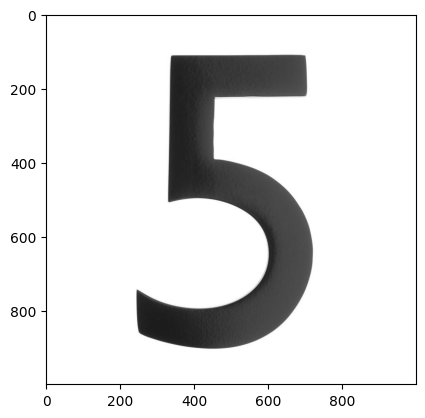

In [ ]:
import requests
from PIL import Image
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

In [ ]:
from PIL import Image
import PIL.ImageOps

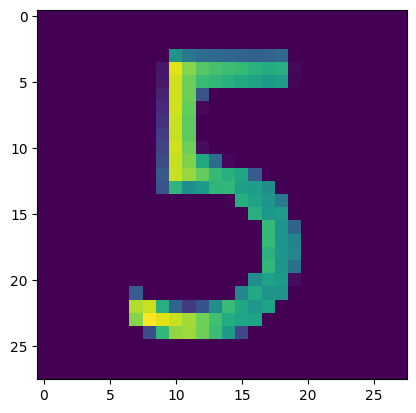

In [ ]:
img = PIL.ImageOps.invert(img)
img = img.convert('L')
img = img.resize((28, 28))
img = transform(img)
plt.imshow(convert(img))

In [ ]:
image = img.unsqueeze(0)
image = image.to(device)
output = model(image)
_,pred = torch.max(output, 1)
print(pred.item())

5


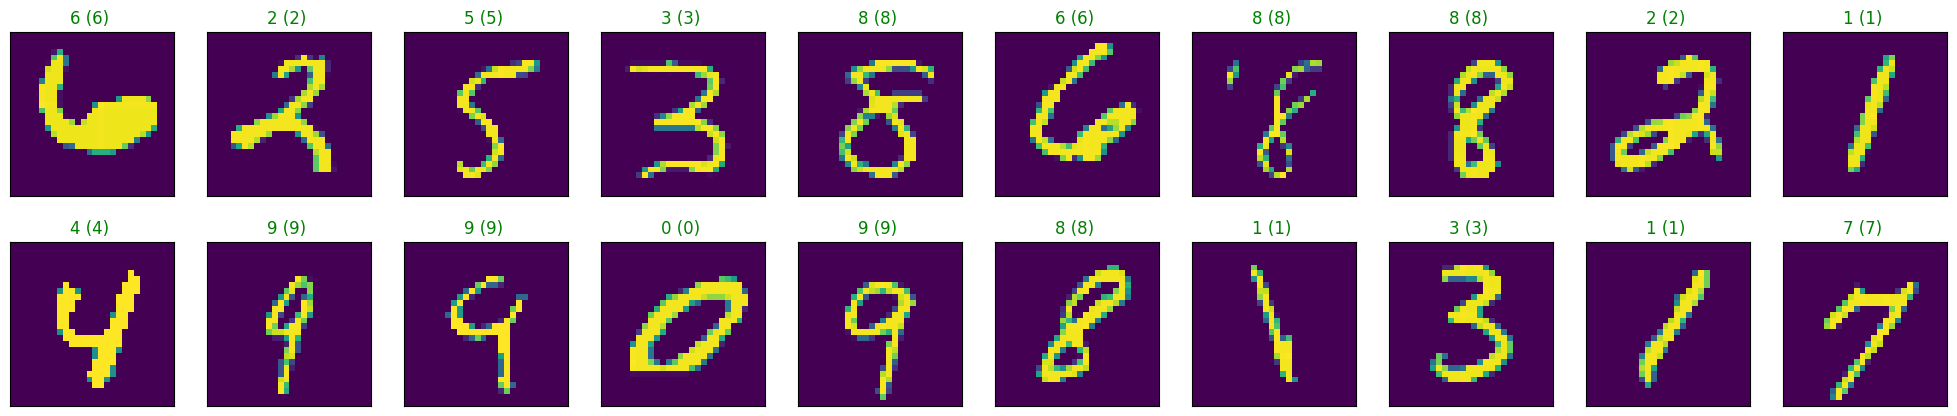

In [ ]:
iteration = iter(training_loader)
images, lable = next(iteration)
images_ = images.to(device)
lable_ = lable.to(device)
output = model(images_)
_,pred = torch.max(output, 1)

fig = plt.figure(figsize=(25, 5))

for i in np.arange(20):
  ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
  plt.imshow(convert(images_[i]))
  ax.set_title("{} ({}) ".format(str(pred[i].item()), str(lable_[i].item())), color= "green" if pred[i]==lable_[i] else "red")